# Image classification of Brain Tumor Dataset

Data source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?datasetId=1608934&sortBy=voteCount

Work is inspired by: 
<br>
[1]https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
<br>
[2]https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96
<br>
[3]chapter08_intro-to-dl-for-computer-vision (Chollet: Deep Learning with Python)
<br>
[4]https://huggingface.co/google/vit-base-patch16-224

## What is Brain Tumor?

A brain tumor is a mass or growth of abnormal cells in the brain or close to it. Brain tumors can be benign (non-cancerous) or malignant (cancerous) and can affect different areas of the brain. They can be primary brain tumors, which start in the brain, or metastatic brain tumors, which spread to the brain from other parts of the body.

Brain tumors can cause a variety of symptoms, depending on their size, location, and rate of growth. Some common symptoms include headaches, seizures, changes in vision, changes in speech, loss of balance or coordination, and cognitive or personality changes. Treatment options for brain tumors include surgery, radiation therapy, chemotherapy, and targeted drug therapy.  (source: chatgpt)

## About the Dataset

Structure of directories: <br>
Training<br>
> -glioma<br>
        -meningioma<br>
        -notumor<br>
        -pituitary<br>

Testing<br>
> -glioma<br>
        -meningioma<br>
        -notumor<br>
        -pituitary<br>

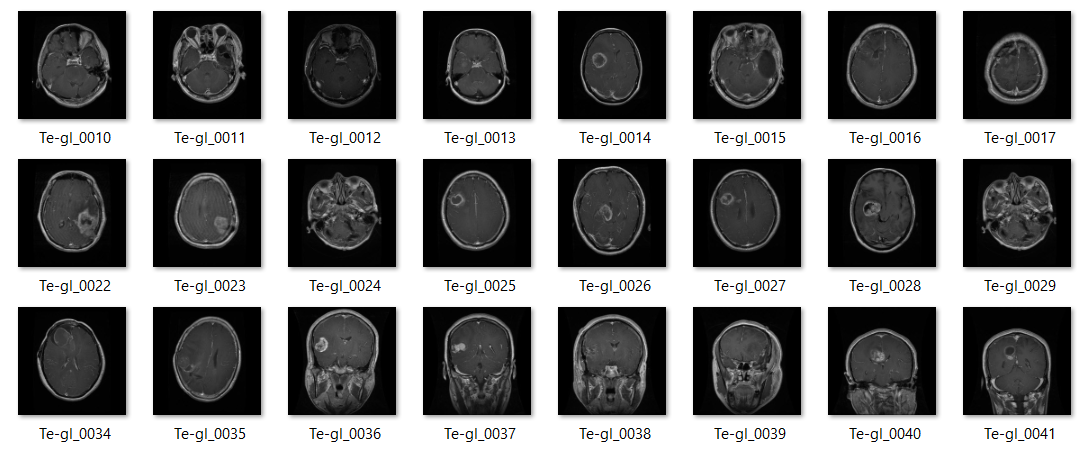

In [ ]:
#raw data sample taken to show images in glioma train dataset
from PIL import Image
image = Image.open("/content/git1.PNG")
from IPython.display import display
display(image)

## Structure of Notebook

1. Importing Libraries
2. Basic Sequential Model
    - Data Preprocessing
    - Extracting features and Labels
    - Train the model
    - Results for training and validation accuracy
3. VGG16 Pretrained Model
    - Data Preprocessing
    - Extracting features and Labels
    - Train the model
    - Results for training and validation accuracy
4. HuggingFace Model
    - Data Preprocessing
    - Extracting features and Labels
    - Train the model
    - Results for training and validation accuracy
5. Conclusions & Results

### Importing required libraries

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import torch

## 1. Basic Sequential model

A sequential model is a type of neural network architecture that is composed of a linear stack of layers. In this architecture, each layer of the model is connected to the previous one, forming a "sequence" of layers. In Keras, a popular deep learning library, a sequential model can be defined using the Sequential class. 

### Assigning data to Training and validation set

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/tumorData/archive.zip

Archive:  /content/drive/MyDrive/tumorData/archive.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
labels = ['glioma', 'meningioma','notumor','pituitary'] #4 labels
img_size = 224

#reading the directories [1]
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:#converts to RGB [2]
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshapes images
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_data('Training/')
val = get_data('Testing/')

C:\Users\email\AppData\Local\Temp\ipykernel_12692\379836260.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [4]:
print(train.shape)

(5712, 2)


In [5]:
print(val.shape)

(1311, 2)


In [12]:
# import random
# # Reduce training data
# subset_size = 1000
# indices = random.sample(range(len(train)), subset_size)
# indices.sort()
# x_train_subset = train[indices]
# y_train_subset = train_labels[indices]


import random

train_list = list(train)
train_subset = random.sample(train_list, 2000)
train_subset = np.array(train_subset)

val_list = list(val)
val_subset = random.sample(val_list, 500)
val_subset = np.array(val_subset)


In [13]:
print(train_subset.shape)

(2000, 2)


In [14]:
print(val_subset.shape)

(500, 2)


 So we have 5712 train Images and 1311 test images

### Resizing? Normalizing Image data

In [15]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train_subset:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val_subset:
  x_val.append(feature)
  y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [18]:
x_train.shape

(2000, 224, 224, 3)

In [19]:
y_train.shape

(2000,)

In [20]:
x_val.shape

(500, 224, 224, 3)

In [21]:
y_val.shape

(500,)

### Train the model

### Model 1

In [11]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(4, activation="softmax"))

model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 64)      

### Dense Layers:

**Relu** - The first dense layer with 128 units applies a linear transformation to the output of the convolutional layers, which can capture more complex features than the convolutional layers alone. The ReLU activation function is then applied to the output of this layer to introduce non-linearity.

**Softmax** - The second dense layer with 4 units and softmax activation is used to produce a probability distribution over the 4 classes in the Brain Tumor dataset.

In [ ]:
history = model.fit(x_train,y_train,epochs = 10 , validation_data = (x_val, y_val))

Epoch 1/10


D:\GeorgeBrownCourses\AnacondaNavigator\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


179/179 [==============================] - 182s 1s/step - loss: 1.3437 - accuracy: 0.2819 - val_loss: 1.3042 - val_accuracy: 0.3089
Epoch 2/10
179/179 [==============================] - 177s 990ms/step - loss: 1.2707 - accuracy: 0.3298 - val_loss: 1.2507 - val_accuracy: 0.3608
Epoch 3/10
179/179 [==============================] - 192s 1s/step - loss: 1.2020 - accuracy: 0.4331 - val_loss: 1.2005 - val_accuracy: 0.5042
Epoch 4/10
179/179 [==============================] - 195s 1s/step - loss: 1.1352 - accuracy: 0.5595 - val_loss: 1.1542 - val_accuracy: 0.5477
Epoch 5/10
179/179 [==============================] - 196s 1s/step - loss: 1.0751 - accuracy: 0.6026 - val_loss: 1.1149 - val_accuracy: 0.5652
Epoch 6/10
179/179 [==============================] - 195s 1s/step - loss: 1.0260 - accuracy: 0.6350 - val_loss: 1.0752 - val_accuracy: 0.5988
Epoch 7/10
179/179 [==============================] - 196s 1s/step - loss: 0.9740 - accuracy: 0.6548 - val_loss: 1.0376 - val_accuracy: 0.6026
Epoch 8

### Results

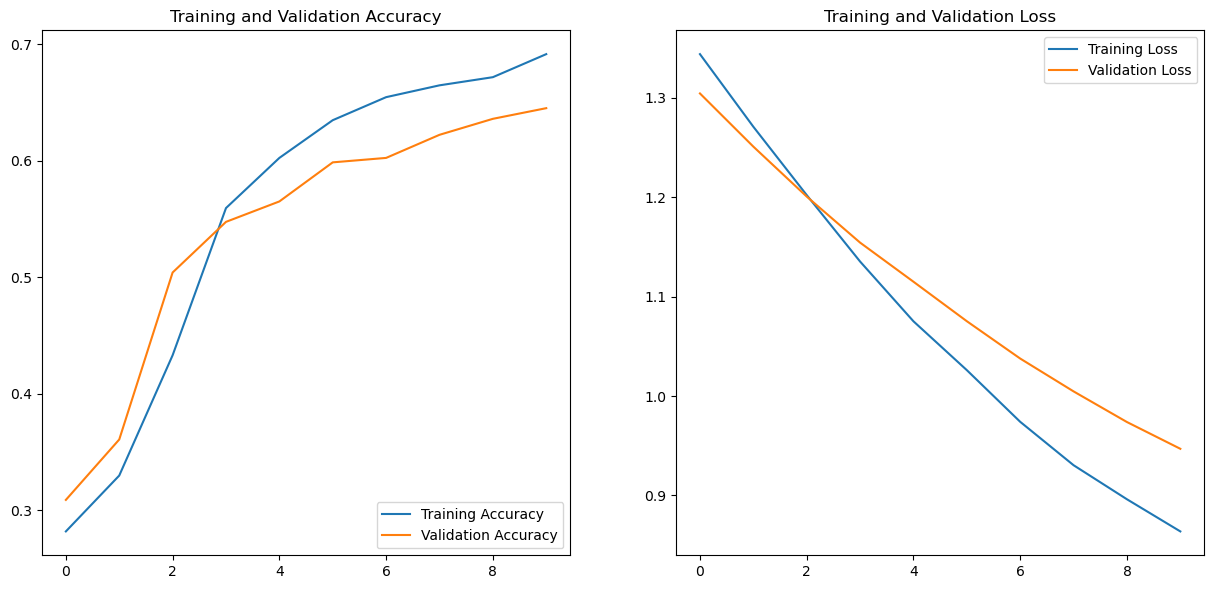

In [ ]:
### Extracting features and labels
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 2

We are adding 64 units in second layer and 128 units in the third layer, instead of 32 and 64 as we saw in model 1

In [22]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(4, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [23]:
history = model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/10
125/125 [==============================] - 171s 1s/step - loss: 0.8636 - accuracy: 0.6405 - val_loss: 0.7476 - val_accuracy: 0.7240
Epoch 2/10
125/125 [==============================] - 160s 1s/step - loss: 0.4936 - accuracy: 0.8030 - val_loss: 0.7128 - val_accuracy: 0.7260
Epoch 3/10
125/125 [==============================] - 148s 1s/step - loss: 0.3138 - accuracy: 0.8755 - val_loss: 0.7824 - val_accuracy: 0.8060
Epoch 4/10
125/125 [==============================] - 154s 1s/step - loss: 0.2104 - accuracy: 0.9125 - val_loss: 0.5258 - val_accuracy: 0.8460
Epoch 5/10
125/125 [==============================] - 153s 1s/step - loss: 0.1484 - accuracy: 0.9465 - val_loss: 0.5208 - val_accuracy: 0.8720
Epoch 6/10
125/125 [==============================] - 151s 1s/step - loss: 0.1032 - accuracy: 0.9630 - val_loss: 0.7359 - val_accuracy: 0.8340
Epoch 7/10
125/125 [==============================] - 149s 1s/step - loss: 0.0705 - accuracy: 0.9710 - val_loss: 0.7319 - val_accuracy: 0.8620

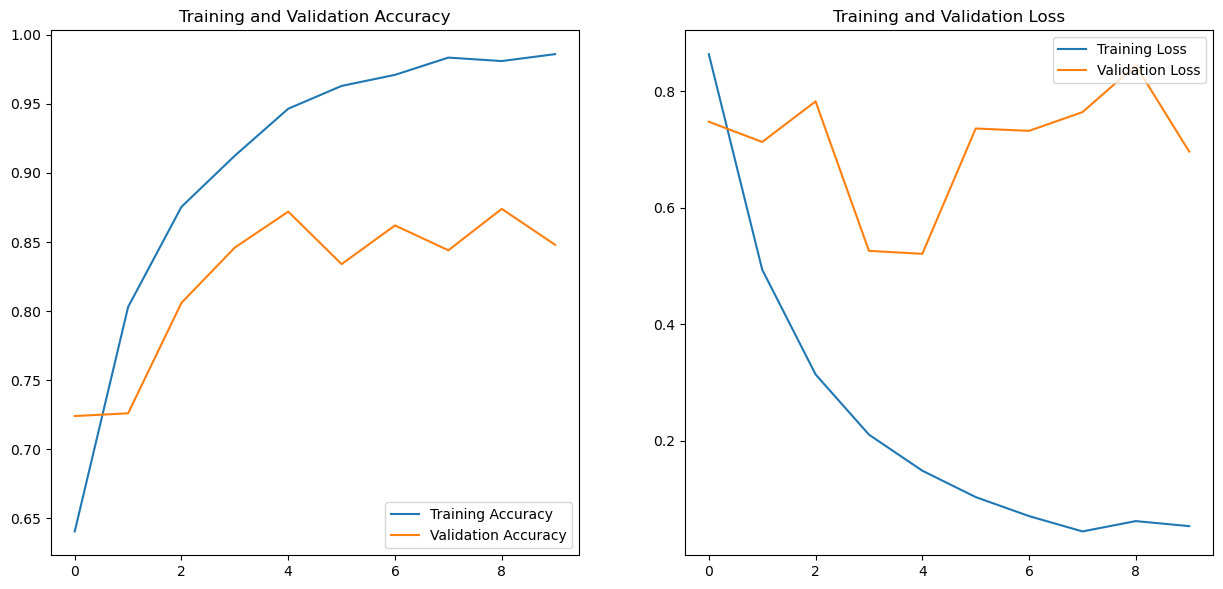

In [25]:
### Extracting features and labels
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although the previous model was trained on entire dataset, this model has been trained on a subset of train and test image due to memory issues. That's why we can see drastic results (higher valdation loss and lower accuarcy) in the results.

## Model 3

## VGG16 base model - pretrained model

VGG16 is a convolutional neural network architecture that was developed by the Visual Geometry Group (VGG) at the University of Oxford. It consists of 16 layers and was designed for image classification tasks. In Keras, VGG16 can be imported from the keras.applications module. 

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", #weights from imagenet, using [3]
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Extracting features and labels

In [ ]:
train_dataset = image_dataset_from_directory(
    "Training",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "Testing",
    image_size=(180, 180),
    batch_size=32)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train)
val_features, val_labels =  get_features_and_labels(val)

1/1 [==============================] - 4s 4s/step


In [ ]:
train_features.shape

(5712, 5, 5, 512)

### Train the model

Training a new classifier (model 3) with weights and biases from pre-trained vgg16

In [ ]:
y_train = to_categorical(train_labels, 4) #to make it compatible with the output layer(else gives errors)
y_val = to_categorical(val_labels, 4)

#training the model[3]
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)


model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="model2.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, y_train,
    epochs=10,
    validation_data=(val_features, y_val),
    callbacks=callbacks)

Epoch 1/10
179/179 [==============================] - 5s 24ms/step - loss: 19.9545 - accuracy: 0.8335 - val_loss: 5.8777 - val_accuracy: 0.9222
Epoch 2/10
179/179 [==============================] - 4s 21ms/step - loss: 6.5870 - accuracy: 0.9263 - val_loss: 8.0392 - val_accuracy: 0.8924
Epoch 3/10
179/179 [==============================] - 4s 23ms/step - loss: 5.1123 - accuracy: 0.9405 - val_loss: 5.3853 - val_accuracy: 0.9359
Epoch 4/10
179/179 [==============================] - 4s 21ms/step - loss: 2.5666 - accuracy: 0.9597 - val_loss: 6.2402 - val_accuracy: 0.9397
Epoch 5/10
179/179 [==============================] - 4s 22ms/step - loss: 2.5779 - accuracy: 0.9636 - val_loss: 3.4688 - val_accuracy: 0.9474
Epoch 6/10
179/179 [==============================] - 4s 22ms/step - loss: 1.3258 - accuracy: 0.9722 - val_loss: 3.7014 - val_accuracy: 0.9428
Epoch 7/10
179/179 [==============================] - 4s 21ms/step - loss: 1.4744 - accuracy: 0.9739 - val_loss: 4.9158 - val_accuracy: 0.946

### Results

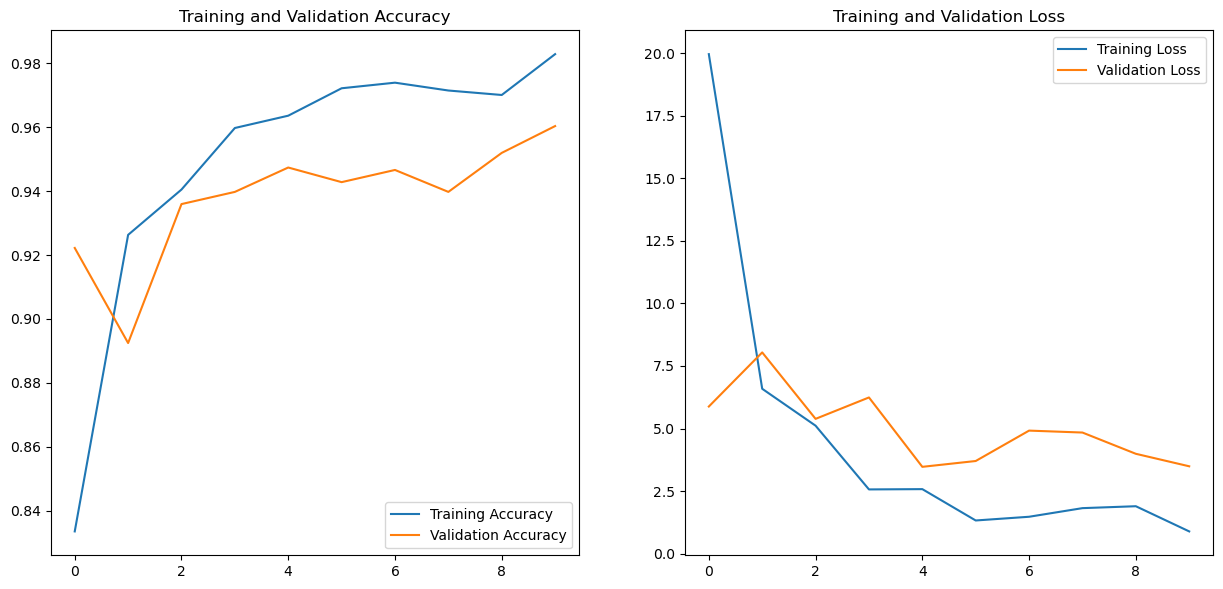

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Model 4

## HuggingFace viT model: google/vit-base-patch16-224

The hugging face google/vit-base-patch16-224 model is a pre-trained transformer model for image classification tasks. It is based on the Vision Transformer (ViT) architecture and was pre-trained on a large dataset of images. To use this model in Python, you can use the transformers library, which provides a convenient interface for loading and using pre-trained models.

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
import tensorflow as tf

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

D:\GeorgeBrownCourses\AnacondaNavigator\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initi

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Training/',
    batch_size=32,
    image_size=(180, 180),
    validation_split=0.2,
    subset='training',
    seed=123
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Testing/',
    batch_size=32,
    image_size=(180, 180),
    validation_split=0.2,
    subset='validation',
    seed=123
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 1311 files belonging to 4 classes.
Using 262 files for validation.


### Extracting features and labels

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        images_norm = images.numpy() / 255.0 #normalize input
        inputs = feature_extractor(images_norm, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs).last_hidden_state
        features = outputs.numpy()
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
#avoid rerun, takes very long
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)

### Train the model

In [ ]:
train_features.shape

(4570, 197, 768)

Training a new classifier (model 4) with weights and biases from pre-trained vit-base-patch16-224

In [ ]:
y_train = to_categorical(train_labels, 4) #to make it compatible with the output layer(else gives errors)
y_val = to_categorical(val_labels, 4)

#training the model[4]
inputs = keras.Input(shape=(197, 768))#obtained from train features
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)


model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="model3.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, y_train,
    epochs=10,
    validation_data=(val_features, y_val),
    callbacks=callbacks)

Epoch 1/10
143/143 [==============================] - 39s 255ms/step - loss: 45.1191 - accuracy: 0.8175 - val_loss: 19.3626 - val_accuracy: 0.8779
Epoch 2/10
143/143 [==============================] - 32s 224ms/step - loss: 15.6889 - accuracy: 0.9151 - val_loss: 22.7705 - val_accuracy: 0.8969
Epoch 3/10
143/143 [==============================] - 35s 246ms/step - loss: 14.0151 - accuracy: 0.9357 - val_loss: 8.5080 - val_accuracy: 0.9580
Epoch 4/10
143/143 [==============================] - 32s 224ms/step - loss: 7.5442 - accuracy: 0.9538 - val_loss: 15.5039 - val_accuracy: 0.9160
Epoch 5/10
143/143 [==============================] - 31s 219ms/step - loss: 3.5933 - accuracy: 0.9733 - val_loss: 11.7288 - val_accuracy: 0.9313
Epoch 6/10
143/143 [==============================] - 31s 217ms/step - loss: 5.1601 - accuracy: 0.9654 - val_loss: 12.6537 - val_accuracy: 0.9466
Epoch 7/10
143/143 [==============================] - 32s 225ms/step - loss: 3.3130 - accuracy: 0.9746 - val_loss: 25.5622

### Results

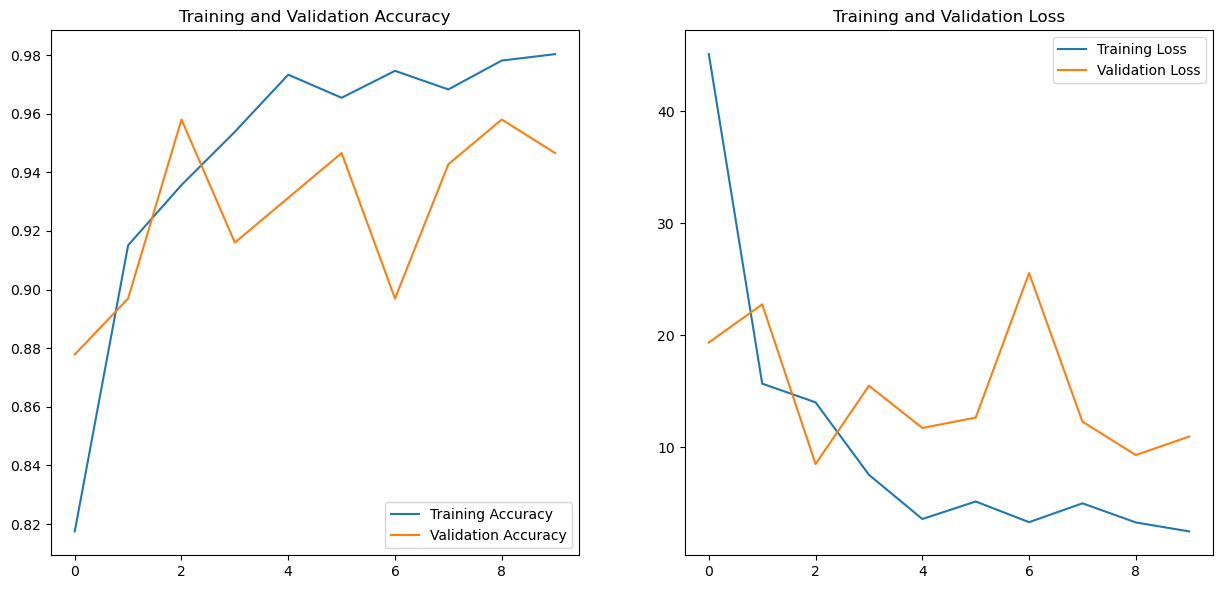

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Model 5

In [36]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", #weights from imagenet, using [3]
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 6s 0us/step


In [37]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Training",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Testing",
    image_size=(180, 180),
    batch_size=32)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [39]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)

1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 7s 7s/step


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
y_train = to_categorical(train_labels, 4) #to make it compatible with the output layer(else gives errors)
y_val = to_categorical(val_labels, 4)

#training the model[3]
inputs = keras.Input(shape=(5, 5, 512))
x = conv_base(x)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)


model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="model2.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, y_train,
    epochs=10,
    validation_data=(val_features, y_val),
    callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Summary of Model Runs

| Model | Conv Layers | Dense Layers | Droupout Layers | Epochs | Batch | Train Loss | Train Accuracy | Validation Loss | Valodation Loss
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Sequential | 3 | 2 | 1| 10 | default | 0.8639 | 0.6917 | 0.9469 | 0.6453 |
| Sequential | 3 | 2 | 1| 10 | 16 | 0.0533 | 0.9860 | 0.6963 | 0.8480 |
| Vgg16 | 0 | 2 | 1| 10 | default | 0.8890 | 0.9828 | 3.4903 | 0.9603 |
| google/vit-base-patch16-224 | 0 | 2 | 1| 10 | default | 2.4876 | 0.9803 | 10.9608 | 0.9466|

## Conclusion:

We trained the dataset from kaggle that consisted of images of brain tumor. We preprocessed the data and then applied two different models. One of the models resulted in a bit smooth curve in regards to validation loss and accuracy while the second model trained on a pretrained(vgg16) provided better validation accuracy, however the graph was fluctuating. Second model performed better in comparison. <br>
In future we aim to increase number of epochs, change parameter values and try to foresee model preformance over a higher epoch value.

## References

Work is inspired by: <br>
[1]https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/ <br>
[2]https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96 <br>
[3]chapter08_intro-to-dl-for-computer-vision (Chollet: Deep Learning with Python)<br>
[4]https://huggingface.co/google/vit-base-patch16-224

By: Murk Asad, Fairouz Sharif